In [196]:
# lien de la compétition Kaggle : https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [198]:
train = pd.read_csv(r"./data/train.csv")
test = pd.read_csv(r"./data/test.csv")
transaction = pd.read_csv(r"./data/transactions.csv")
stores = pd.read_csv(r"./data/stores.csv")
oil = pd.read_csv(r"./data/oil.csv")
holidays_events = pd.read_csv(r"./data/holidays_events.csv")


# Analyse descriptives

In [199]:
liste_des_df = {"train":train, "test":test, "transaction":transaction, "stores":stores, "oil":oil, "holidays_events":holidays_events}

In [200]:
for col in liste_des_df.keys():
    print(col, liste_des_df[col].shape)

train (3000888, 6)
test (28512, 5)
transaction (83488, 3)
stores (54, 5)
oil (1218, 2)
holidays_events (350, 6)


## Evlauer le pourcentage de valeurs manquantes pour chaque dataframe

### Pour la dataframe train

In [201]:
missing_percentages_train = train.isnull().mean() * 100
print(missing_percentages_train)

id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64


### Pour la dataframe transaction

In [202]:
missing_percentages_transaction = transaction.isnull().mean() * 100
print(missing_percentages_transaction)

date            0.0
store_nbr       0.0
transactions    0.0
dtype: float64


### Pour la dataframe oil

In [203]:
missing_percentages_oil = oil.isnull().mean() * 100
print(missing_percentages_oil)

date          0.000000
dcoilwtico    3.530378
dtype: float64


### Pour la dataframe stores

In [204]:
missing_percentages_stores = stores.isnull().mean() * 100
print(missing_percentages_stores)

store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64


### Pour la dataframe holidays events

In [205]:
missing_percentages_holidays_events = holidays_events.isnull().mean() * 100
print(missing_percentages_holidays_events)

date           0.0
type           0.0
locale         0.0
locale_name    0.0
description    0.0
transferred    0.0
dtype: float64


#### On s'apecoit qu'aucune dataframe n'as de valeurs manquantes sauf la dataframe oil

# Analyse les colonnes catégorielles

## Infos sur la dataframe train

In [206]:
print(train.info()) # la colonne date est en object peut etre vaudrait mieux la transformer en datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [207]:
train['date'] = pd.to_datetime(train['date'])

In [208]:
object_columns_train = train.select_dtypes(include=['object']).columns.tolist()
print(object_columns_train)

['family']


#### Nombre de modalitées de chaque variable catégorielle 

In [209]:
d = {}

for i in object_columns_train:
    d["nombre de modalités "+i] = train[i].nunique()

print(d)

{'nombre de modalités family': 33}


In [210]:
numerique_columns_train = train.select_dtypes(include=['int', "float"]).columns.tolist()
numerique_columns_train.remove("id")
numerique_columns_train.remove("sales")
print(numerique_columns_train)

['store_nbr', 'onpromotion']


In [211]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## dataframe Oil
### Imputations des valeurs manquantes par la médiane 

In [212]:
oil['date'] = pd.to_datetime(oil['date'])

In [213]:
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(oil["dcoilwtico"].median())

In [214]:
missing_percentages_oil = oil.isnull().mean() * 100
print(missing_percentages_oil)

date          0.0
dcoilwtico    0.0
dtype: float64


In [215]:
oil["date"].nunique()

1218

## Vérification de la linéarité des colonnes continues en fonctions de la variables cible 

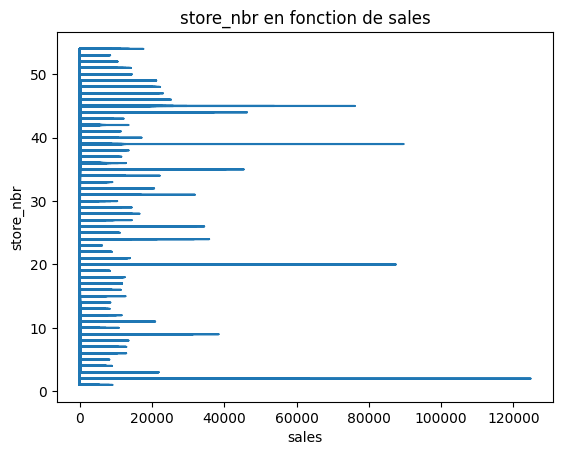

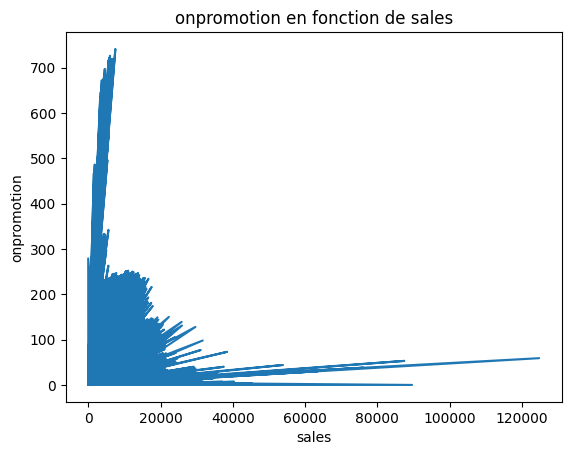

In [216]:
for col in numerique_columns_train:
    plt.title(f"{col} en fonction de sales")
    plt.ylabel(col)
    plt.xlabel("sales")
    plt.plot(train["sales"],train[col])
    plt.show()

## Infos sur la dataframe oil

In [217]:
print(oil.info()) # la colonne date est en object peut etre vaudrait mieux la transformer en datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


In [218]:
object_columns_train = train.select_dtypes(include=['object']).columns.tolist()
print(object_columns_train)

['family']


# Début du merging des dataframe

In [219]:
train = pd.merge(train, oil, on="date", how="left")

In [220]:
train = pd.merge(train, stores, on="store_nbr", how="left")

In [221]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,53.19,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,53.19,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,53.19,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,53.19,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,53.19,Quito,Pichincha,D,13


# Modèle random forest

In [222]:
object_columns = train.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

['family', 'city', 'state', 'type']


In [223]:
train = pd.get_dummies(train, columns=['family'])
train = pd.get_dummies(train, columns=['city'])
train = pd.get_dummies(train, columns=['state'])
train = pd.get_dummies(train, columns=['type'])

In [224]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Supposons que vous avez déjà un DataFrame df avec vos données

# Séparer les caractéristiques (features) et la variable cible
X = train.drop(['sales','date'], axis=1)  # Features
y = train['sales']  # Target variable

# Diviser l'ensemble de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un modèle de Random Forest pour la régression
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Entraîner le modèle sur l'ensemble d'entraînement
random_forest_regressor.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = random_forest_regressor.predict(X_test)

# Calculer l'erreur quadratique moyenne logarithmique (RMSLE) du modèle
rmsle = np.sqrt(np.mean((np.log1p(y_test) - np.log1p(predictions))**2))
print("RMSLE du modèle de Random Forest :", rmsle)


RMSLE du modèle de Random Forest : 0.5347739016949865


# Entrainenement sur la Base test

In [225]:
test['date'] = pd.to_datetime(test['date'])

In [226]:
test = pd.merge(test, oil, on="date", how="left")
test = pd.merge(test, stores, on="store_nbr", how="left")

In [227]:
test = pd.get_dummies(test, columns=['family'])
test = pd.get_dummies(test, columns=['city'])
test = pd.get_dummies(test, columns=['state'])
test = pd.get_dummies(test, columns=['type'])

In [228]:
test.drop(["date"], axis=1, inplace=True)

predictions = random_forest_regressor.predict(test)

# Afficher les prédictions
print(predictions)

[   3.71          0.            7.35       ... 1229.48193     124.49
   18.42417998]


In [229]:
print(len(predictions))

28512


In [230]:
sub = {"id":test["id"], "sales":predictions}

In [231]:
submission = pd.DataFrame(sub)
submission

,id,sales
0,3000888,3.71000
1,3000889,0.00000
2,3000890,7.35000
3,3000891,2105.79000
4,3000892,0.08000
...,...,...
28507,3029395,360.60739
28508,3029396,98.82575
28509,3029397,1229.48193
28510,3029398,124.49000


In [232]:
submission.to_csv(r"./data/submissions.csv", index=False)